In [30]:
import sys
%pylab inline
sys.path.insert(0,"../src")

Populating the interactive namespace from numpy and matplotlib


In [31]:
import utils
import os
import data
import tree_split

In [32]:
rawtraindf, traindf, testdf, submissiondf = data.get_data(return_normalized=True, onehot=True,train_expand=True)

['Sex', 'base_Weeks', 'SmokingStatus_2', 'weeks_since_base', 'base_FVC', 'Age', 'base_Percent', 'base_ref_FVC', 'SmokingStatus_1']
rmse: 225.53770072803806 mean err: -4.798894508109523e-13


In [33]:
traindf=traindf[traindf['weeks_since_base']>0]

In [34]:
for u in [rawtraindf, traindf, testdf, submissiondf]:
    print(u.shape)

(1542, 15)
(5919, 21)
(5, 18)
(730, 13)


In [35]:
traindf.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'base_Weeks', 'base_FVC',
       'base_Percent', 'Age', 'Sex', 'SmokingStatus_1', 'SmokingStatus_2',
       'base_ref_FVC', 'weeks_since_base', 'log_FVC', 'log_base_FVC',
       'norm_FVC', 'norm_Age', 'norm_base_Percent', 'norm_base_FVC',
       'norm_base_ref_FVC', 'norm_weeks_since_base'],
      dtype='object')

In [6]:
traindf.head()

Patient  Weeks     FVC    Percent  base_Weeks  base_FVC  \
9   ID00218637202258156844710     22  2550.0  82.534956          20    2439.0   
10  ID00218637202258156844710     25  2590.0  83.829622          20    2439.0   
11  ID00218637202258156844710     26  2564.0  82.988089          20    2439.0   
12  ID00218637202258156844710     29  2582.0  83.570689          20    2439.0   
13  ID00218637202258156844710     34  2527.0  81.790523          20    2439.0   

    base_Percent  Age  Sex  SmokingStatus_1  ...  base_ref_FVC  \
9      78.942258   81    0                1  ...        3089.6   
10     78.942258   81    0                1  ...        3089.6   
11     78.942258   81    0                1  ...        3089.6   
12     78.942258   81    0                1  ...        3089.6   
13     78.942258   81    0                1  ...        3089.6   

    weeks_since_base   log_FVC  log_base_FVC  norm_FVC  norm_Age  \
9                  2  7.843849      7.799343 -0.169988  1.953506   
10                 5  7.859413      7.799343 -0.121953  1.953506   
11                 6  7.849324      7.799343 -0.153176  1.953506   
12                 9  7.856320      7.799343 -0.131560  1.953506   
13                14  7.834788      7.799343 -0.197607  1.953506   

    norm_base_Percent  norm_base_FVC  norm_base_ref_FVC  norm_weeks_since_base  
9            -0.07921       -0.41713          -0.545736              -0.874166  
10           -0.07921       -0.41713          -0.545736              -0.703839  
11           -0.07921       -0.41713          -0.545736              -0.647064  
12           -0.07921       -0.41713          -0.545736              -0.476738  
13           -0.07921       -0.41713          -0.545736              -0.192860  

[5 rows x 21 columns]

In [7]:
FEATS= [x for x in traindf.columns if x.startswith('norm_') and x !="norm_FVC"] + ['Sex', 'SmokingStatus_1','SmokingStatus_2']


In [8]:
traindf[FEATS].describe()

norm_Age  norm_base_Percent  norm_base_FVC  norm_base_ref_FVC  \
count  5919.000000        5919.000000    5919.000000        5919.000000   
mean     -0.006537          -0.060873      -0.046591           0.003616   
std       1.001603           1.006028       0.997934           1.008240   
min      -2.578826          -2.641133      -2.345262          -2.551444   
25%      -0.595931          -0.807777      -0.752041          -0.545736   
50%       0.112246          -0.148894      -0.095376           0.219035   
75%       0.678788           0.484231       0.537367           0.703946   
max       2.944954           3.763761       4.319471           1.921337   

       norm_weeks_since_base          Sex  SmokingStatus_1  SmokingStatus_2  
count            5919.000000  5919.000000      5919.000000      5919.000000  
mean                0.181010     0.213719         0.670552         0.052712  
std                 0.908382     0.409965         0.470052         0.223476  
min                -0.930941     0.000000         0.000000         0.000000  
25%                -0.647064     0.000000         0.000000         0.000000  
50%                -0.022534     0.000000         1.000000         0.000000  
75%                 0.829098     0.000000         1.000000         0.000000  
max                 2.589137     1.000000         1.000000         1.000000

In [9]:
traindf.shape

(5919, 21)

In [10]:
testdf[FEATS].describe()

norm_Age  norm_base_Percent  norm_base_FVC  norm_base_ref_FVC  \
count  5.000000           5.000000       5.000000           5.000000   
mean   0.650461          -0.231708      -0.007342           0.245084   
std    0.307058           0.257445       0.617763           1.006235   
min    0.112246          -0.532651      -1.025951          -1.315889   
25%    0.678788          -0.447813      -0.058297          -0.210981   
50%    0.820423          -0.196760       0.164180           0.776602   
75%    0.820423          -0.062811       0.277811           0.889084   
max    0.820423           0.081496       0.605545           1.086601   

       norm_weeks_since_base  Sex  SmokingStatus_1  SmokingStatus_2  
count               5.000000  5.0         5.000000              5.0  
mean               -0.987717  0.0         0.800000              0.0  
std                 0.000000  0.0         0.447214              0.0  
min                -0.987717  0.0         0.000000              0.0  
25%                -0.987717  0.0         1.000000              0.0  
50%                -0.987717  0.0         1.000000              0.0  
75%                -0.987717  0.0         1.000000              0.0  
max                -0.987717  0.0         1.000000              0.0

In [11]:
str(FEATS)

"['norm_Age', 'norm_base_Percent', 'norm_base_FVC', 'norm_base_ref_FVC', 'norm_weeks_since_base', 'Sex', 'SmokingStatus_1', 'SmokingStatus_2']"

In [12]:
traindf['FVCdiff']=traindf['norm_FVC']-traindf['norm_base_FVC']

In [13]:
folds=data.make_kfold(traindf)

In [14]:
from statsmodels.robust.scale import huber
def laplace_loss2(y_pred, sigma_pred, y_true):
    SCALE=data.scalers['FVC'].scale_
    #SCALE=1
    C1=70./SCALE
    C2=1000./SCALE    
    sigma = sigma_pred.copy()
    sigma[sigma<C1]=C1
    delta = np.abs(y_true - y_pred)
    delta[delta>C2]=C2
    sq2 = np.sqrt(2)
    metric = (delta / sigma)*sq2 + np.log(sigma* sq2) +np.log(SCALE)
    return metric

def helper_loss(model_pred, y_true):
    X=model_pred['y']
    if 0:
        y_pred=X.mean(0)
        sigma_pred=X.std(0)
    else:
        y_pred, sigma_pred =np.apply_along_axis(huber,axis=0, arr=X)

    return laplace_loss2(y_pred, sigma_pred, y_true)

In [15]:
from sklearn.linear_model import Ridge

def model_factory(df, FEATS, priors, TARGET="FVCdiff"):
    x = df[FEATS].values
    y = df[TARGET].values
    fm = TARGET + " ~ " + " + ".join(FEATS)
    with pm.Model() as model:
        family = pm.glm.families.StudentT()
        pm.GLM.from_formula(fm, data=df, priors=priors, family=family)
    return model

In [16]:
traindf.shape

(5919, 22)

In [17]:
TARGET="FVCdiff"
TARGET,FEATS

('FVCdiff',
 ['norm_Age',
  'norm_base_Percent',
  'norm_base_FVC',
  'norm_base_ref_FVC',
  'norm_weeks_since_base',
  'Sex',
  'SmokingStatus_1',
  'SmokingStatus_2'])

In [18]:
import pymc3 as pm
import arviz as az

RANDOM_SEED=123
def train(traindf,testdf, FEATS, TARGET,n_trace=2000):
    global priors
    if 1:
        ridge = Ridge().fit(traindf[FEATS].values, traindf[TARGET].values)
        print(ridge.intercept_, ridge.coef_)
        priors = {'Intercept': pm.Normal.dist(mu=ridge.intercept_, sigma=100),
                    }
        priors.update({name:pm.Normal.dist(mu=v,sigma=100) for name,v in zip(FEATS,ridge.coef_)})            
    with model_factory(traindf, FEATS, priors)  as model:
        #trace = pm.sample(10000,init='adapt_diag', return_inferencedata=False,random_seed=RANDOM_SEED)
        trace = pm.sample(n_trace, tune=n_trace, return_inferencedata=False, target_accept=.9, cores=1, init="adapt_diag")

        idata=az.from_pymc3(trace) 
        display(az.summary(idata, round_to=2))
        az.plot_trace(idata);plt.show()
        az.plot_forest(idata, r_hat=True, combined=True, textsize=9);plt.show()
        post_pred = pm.sample_posterior_predictive(idata, samples=1000,random_seed=RANDOM_SEED)
        train_loss=helper_loss(post_pred,traindf[TARGET].values).mean()
    with model_factory(testdf,FEATS, priors) as test_model:
        post_pred = pm.sample_posterior_predictive(idata, samples=1000,random_seed=RANDOM_SEED) 
        test_loss=helper_loss(post_pred,testdf[TARGET].values).mean()
    return train_loss, test_loss
    

In [19]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Run

In [20]:
#os.environ['LR_FEATS']= ",".join(FEATS)

In [21]:
import os
LR_FEATS=os.environ['LR_FEATS'].split(",")
print("Use feat", LR_FEATS)

Use feat ['norm_Age', 'norm_base_Percent', 'norm_base_FVC', 'norm_base_ref_FVC', 'norm_weeks_since_base', 'Sex', 'SmokingStatus_1', 'SmokingStatus_2']


0.018880472892851666 [ 0.00551633 -0.01433424 -0.00493346 -0.01515583 -0.06579285 -0.02653759
  0.01178142  0.14883461]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, SmokingStatus_2, SmokingStatus_1, Sex, norm_weeks_since_base, norm_base_ref_FVC, norm_base_FVC, norm_base_Percent, norm_Age, Intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept               0.05  0.01    0.04     0.06       0.00     0.00   
norm_Age                0.00  0.00   -0.00     0.01       0.00     0.00   
norm_base_Percent      -0.03  0.01   -0.05    -0.01       0.00     0.00   
norm_base_FVC           0.01  0.01   -0.01     0.04       0.00     0.00   
norm_base_ref_FVC      -0.03  0.01   -0.05    -0.01       0.00     0.00   
norm_weeks_since_base  -0.06  0.00   -0.06    -0.05       0.00     0.00   
Sex                    -0.05  0.01   -0.07    -0.02       0.00     0.00   
SmokingStatus_1        -0.01  0.01   -0.02     0.01       0.00     0.00   
SmokingStatus_2         0.12  0.01    0.10     0.14       0.00     0.00   
lam                    75.62  2.89   70.21    81.02       0.04     0.03   

                       ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
Intercept               2528.52  2528.52   2532.95   2574.93    1.0  
norm_Age                3701.37  3278.31   3718.44   2741.18    1.0  
norm_base_Percent       2051.74  1908.23   2049.75   1864.69    1.0  
norm_base_FVC           2063.88  1679.93   2068.39   1873.79    1.0  
norm_base_ref_FVC       2058.58  1904.50   2065.44   2261.77    1.0  
norm_weeks_since_base   3963.12  3952.29   3962.56   2988.32    1.0  
Sex                     3085.33  3084.75   3086.50   2882.93    1.0  
SmokingStatus_1         2906.48  2800.58   2904.91   2853.32    1.0  
SmokingStatus_2         3464.54  3462.66   3465.94   3112.70    1.0  
lam                     4181.15  4181.15   4171.37   2571.10    1.0

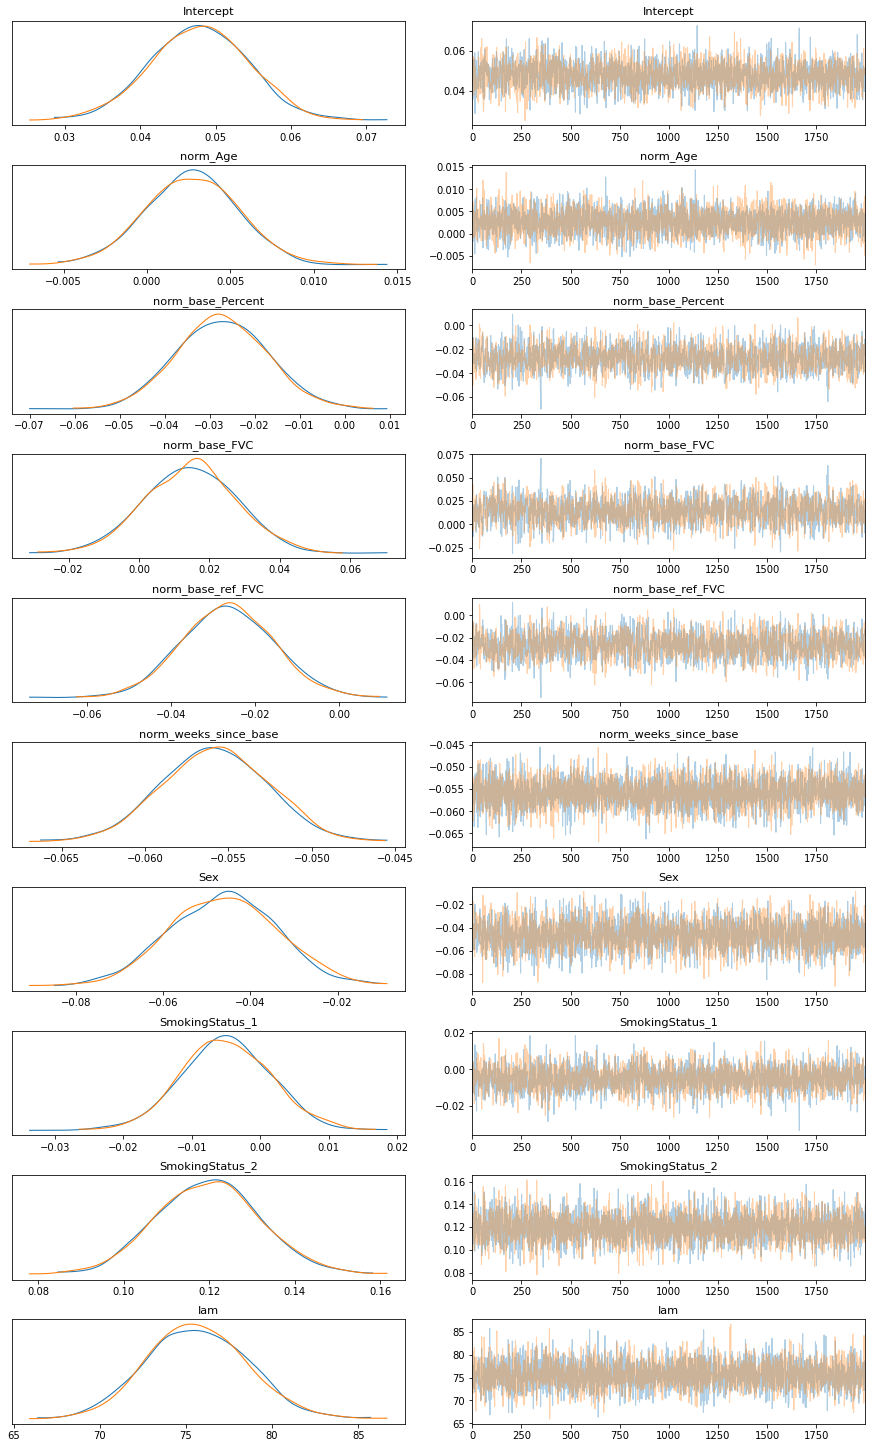

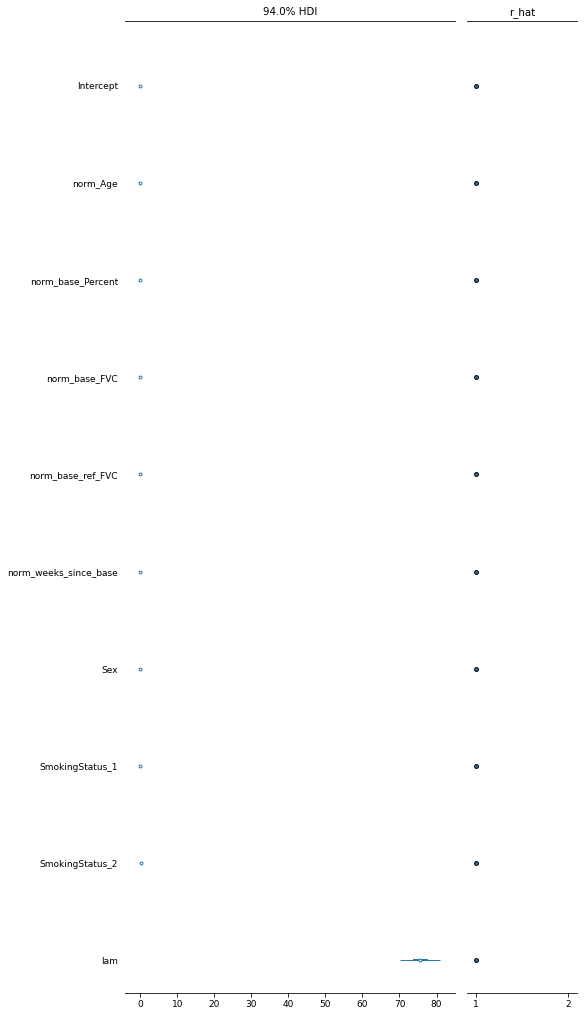

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.620104214225069, 6.690837014641548]
-0.002463814350973443 [ 0.01252388  0.01181334 -0.04658634  0.03279716 -0.07256325  0.0445061
  0.01769551  0.1475169 ]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, SmokingStatus_2, SmokingStatus_1, Sex, norm_weeks_since_base, norm_base_ref_FVC, norm_base_FVC, norm_base_Percent, norm_Age, Intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept               0.03  0.01    0.02     0.04       0.00     0.00   
norm_Age                0.01  0.00    0.01     0.02       0.00     0.00   
norm_base_Percent      -0.01  0.01   -0.03     0.01       0.00     0.00   
norm_base_FVC          -0.02  0.01   -0.04     0.01       0.00     0.00   
norm_base_ref_FVC       0.00  0.01   -0.02     0.02       0.00     0.00   
norm_weeks_since_base  -0.06  0.00   -0.07    -0.05       0.00     0.00   
Sex                    -0.01  0.01   -0.03     0.02       0.00     0.00   
SmokingStatus_1         0.01  0.01   -0.01     0.02       0.00     0.00   
SmokingStatus_2         0.11  0.02    0.08     0.14       0.00     0.00   
lam                    71.83  2.72   66.58    76.80       0.04     0.03   

                       ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
Intercept               2505.04  2505.04   2494.50   2465.68    1.0  
norm_Age                3557.96  3548.81   3544.11   3089.01    1.0  
norm_base_Percent       1997.23  1820.61   2004.41   2403.98    1.0  
norm_base_FVC           2113.92  2113.92   2128.13   2553.46    1.0  
norm_base_ref_FVC       2223.26  2080.41   2230.32   2320.11    1.0  
norm_weeks_since_base   4271.61  4271.61   4255.00   2460.91    1.0  
Sex                     2855.16  2536.05   2846.02   3017.63    1.0  
SmokingStatus_1         2917.25  2734.01   2916.61   2757.96    1.0  
SmokingStatus_2         3480.50  3429.23   3484.33   3050.59    1.0  
lam                     4169.50  4134.10   4198.95   2617.23    1.0

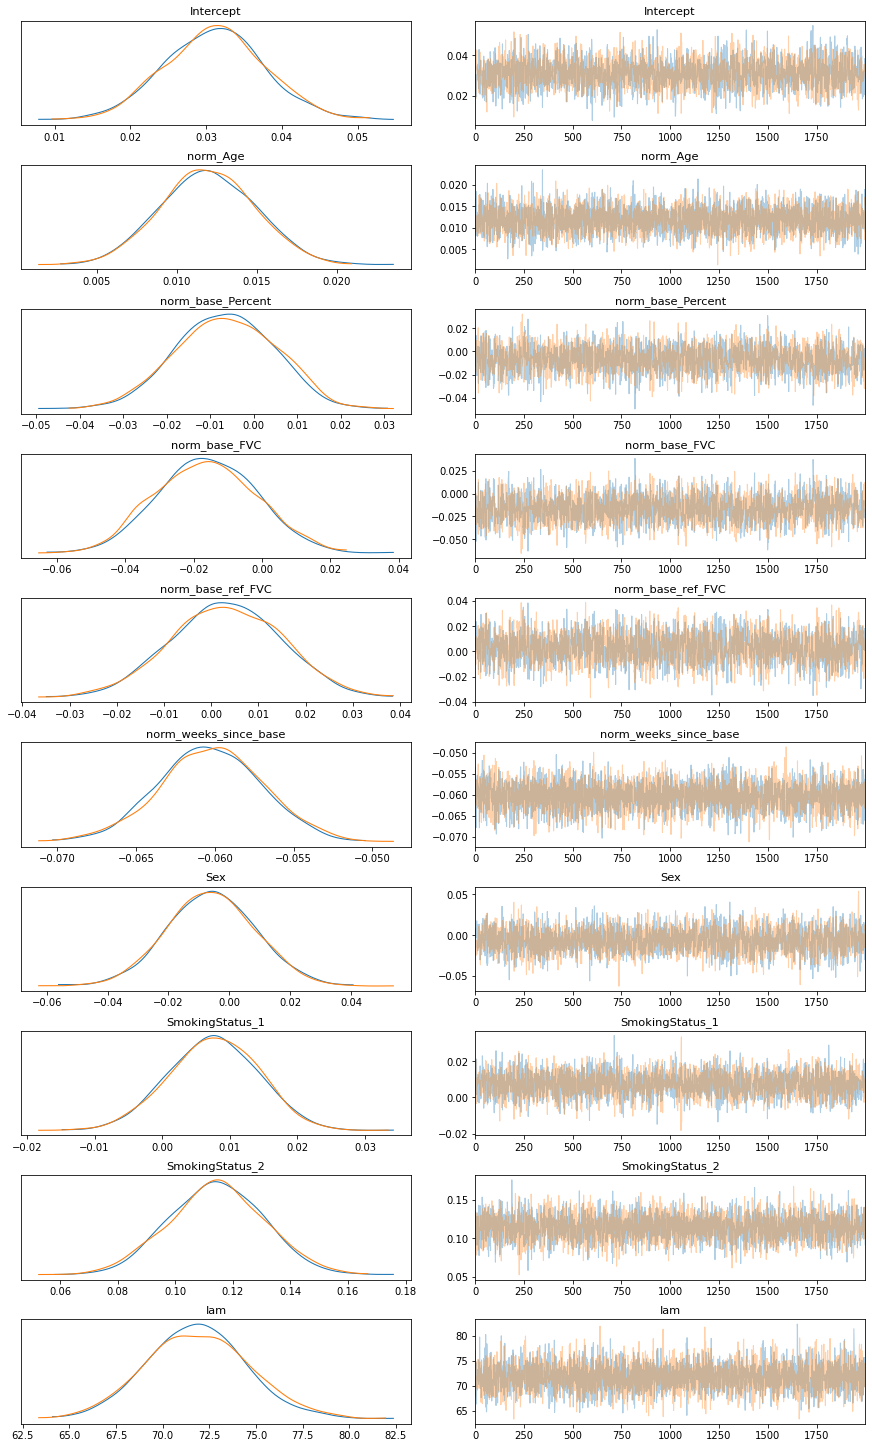

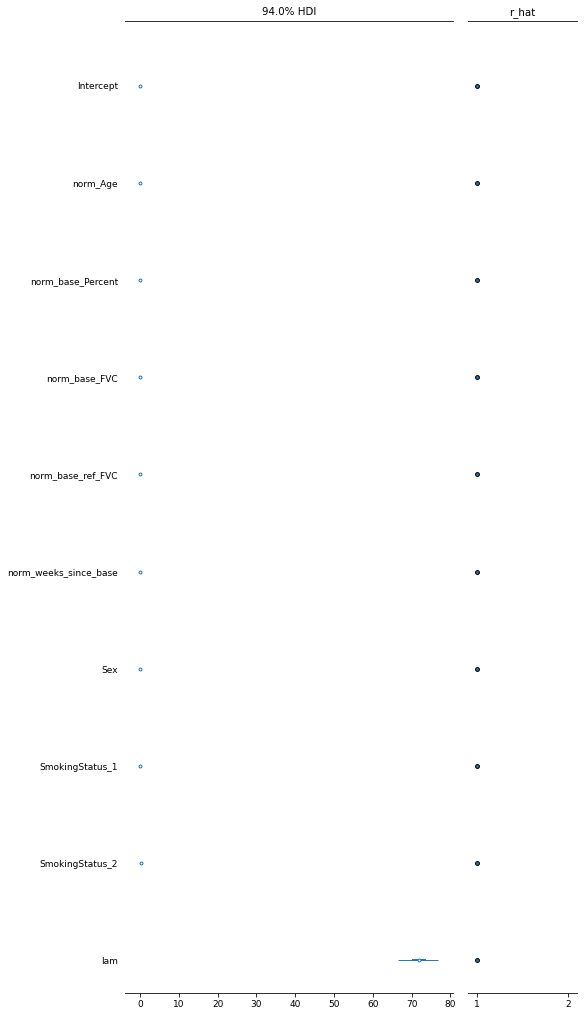

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.634609568399486, 6.626062360523324]
0.010437835960880925 [ 0.00507919  0.00402255 -0.03408035  0.00518042 -0.068501   -0.02723304
  0.02255198  0.158691  ]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, SmokingStatus_2, SmokingStatus_1, Sex, norm_weeks_since_base, norm_base_ref_FVC, norm_base_FVC, norm_base_Percent, norm_Age, Intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept               0.04  0.01    0.03     0.05       0.00     0.00   
norm_Age                0.00  0.00   -0.00     0.01       0.00     0.00   
norm_base_Percent      -0.01  0.01   -0.03     0.01       0.00     0.00   
norm_base_FVC          -0.01  0.01   -0.04     0.01       0.00     0.00   
norm_base_ref_FVC      -0.01  0.01   -0.03     0.01       0.00     0.00   
norm_weeks_since_base  -0.05  0.00   -0.06    -0.05       0.00     0.00   
Sex                    -0.03  0.01   -0.06    -0.01       0.00     0.00   
SmokingStatus_1         0.01  0.01   -0.00     0.02       0.00     0.00   
SmokingStatus_2         0.13  0.01    0.10     0.15       0.00     0.00   
lam                    77.63  2.97   71.99    83.14       0.04     0.03   

                       ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
Intercept               2249.40  2206.88   2249.13   2102.96    1.0  
norm_Age                3364.12  2609.59   3358.51   2736.92    1.0  
norm_base_Percent       2319.53  2319.53   2321.64   2322.07    1.0  
norm_base_FVC           2280.36  1837.55   2284.69   1981.61    1.0  
norm_base_ref_FVC       2311.04  2193.65   2305.98   2489.05    1.0  
norm_weeks_since_base   3705.52  3683.42   3700.69   2912.85    1.0  
Sex                     2974.77  2974.77   2972.81   2735.53    1.0  
SmokingStatus_1         2691.91  2461.15   2690.93   2724.12    1.0  
SmokingStatus_2         2884.13  2884.13   2906.32   2640.51    1.0  
lam                     4768.49  4768.49   4757.17   2908.44    1.0

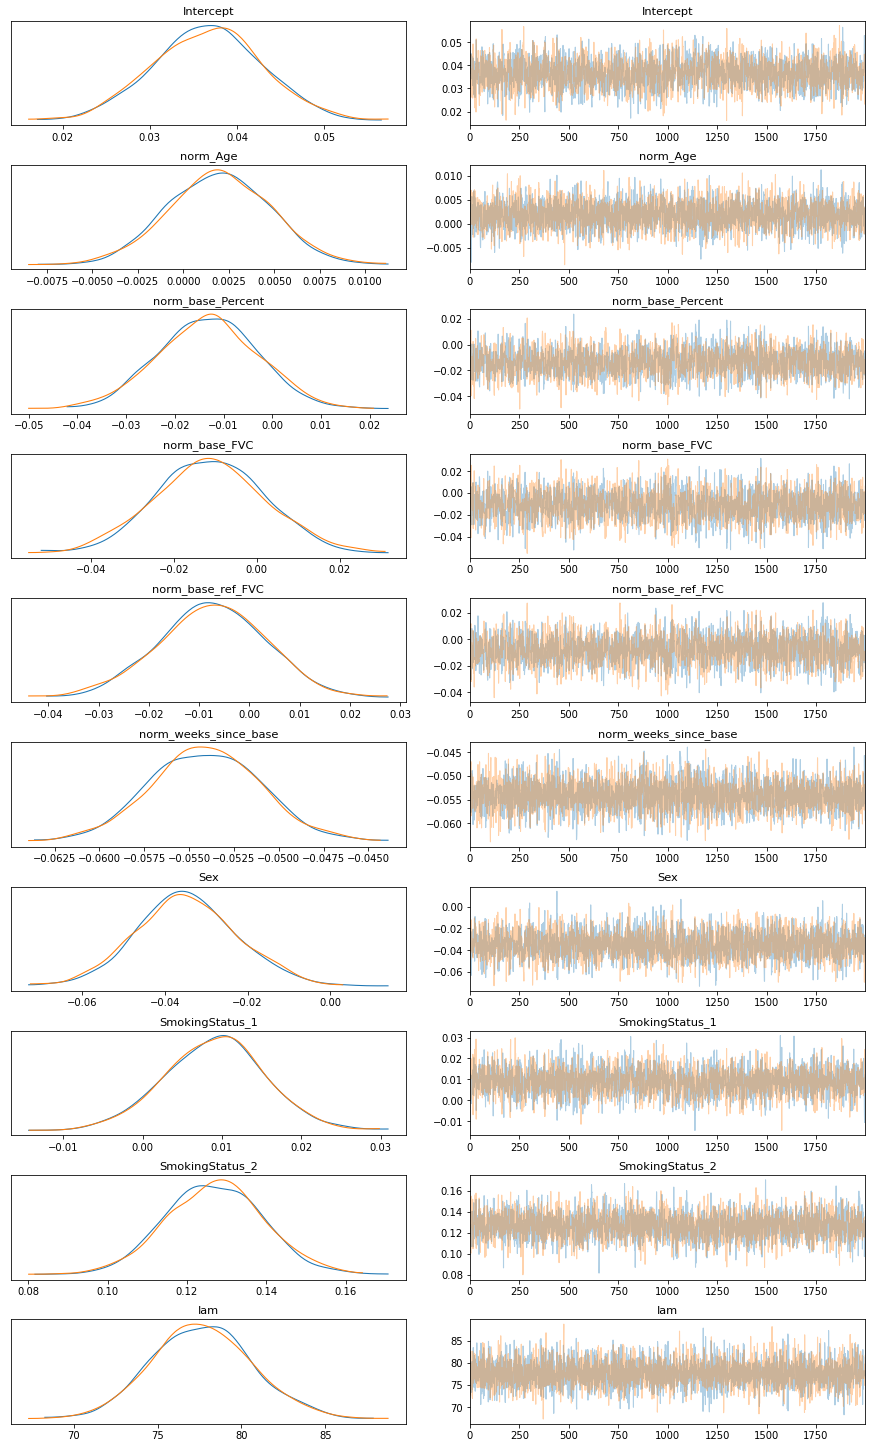

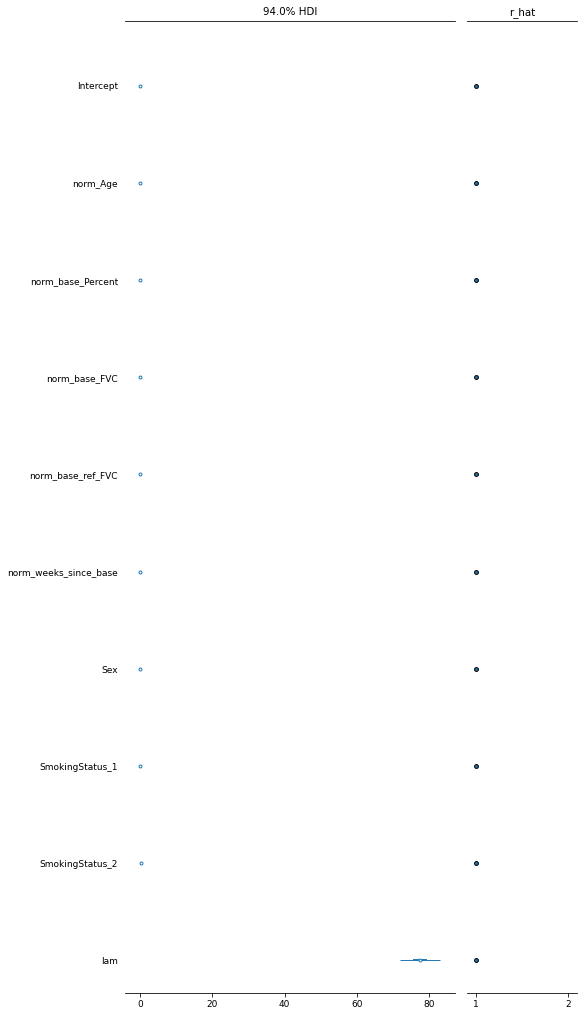

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.6079580206943, 6.755309537925161]
0.005781775502103066 [ 0.0089623   0.01879131 -0.04776165  0.02591012 -0.06654697  0.01039006
  0.00736387  0.15806989]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, SmokingStatus_2, SmokingStatus_1, Sex, norm_weeks_since_base, norm_base_ref_FVC, norm_base_FVC, norm_base_Percent, norm_Age, Intercept]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept               0.03  0.01    0.02     0.05       0.00     0.00   
norm_Age                0.01  0.00    0.00     0.01       0.00     0.00   
norm_base_Percent       0.01  0.01   -0.01     0.04       0.00     0.00   
norm_base_FVC          -0.03  0.02   -0.06    -0.00       0.00     0.00   
norm_base_ref_FVC       0.02  0.01   -0.00     0.04       0.00     0.00   
norm_weeks_since_base  -0.06  0.00   -0.07    -0.05       0.00     0.00   
Sex                    -0.01  0.01   -0.04     0.01       0.00     0.00   
SmokingStatus_1        -0.00  0.01   -0.01     0.01       0.00     0.00   
SmokingStatus_2         0.12  0.02    0.09     0.16       0.00     0.00   
lam                    71.44  2.63   66.71    76.60       0.04     0.03   

                       ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
Intercept               2848.62  2834.21   2852.51   2582.05    1.0  
norm_Age                4274.84  3932.21   4295.10   3489.05    1.0  
norm_base_Percent       1945.26  1793.87   1952.88   2548.52    1.0  
norm_base_FVC           1976.65  1829.42   1981.35   2416.80    1.0  
norm_base_ref_FVC       2067.71  1903.63   2068.57   2418.25    1.0  
norm_weeks_since_base   4651.55  4603.46   4647.25   3308.45    1.0  
Sex                     3345.82  2900.77   3347.74   2639.58    1.0  
SmokingStatus_1         3323.52  2345.56   3321.11   2653.05    1.0  
SmokingStatus_2         3587.77  3587.77   3591.38   2893.83    1.0  
lam                     4094.83  4094.83   4067.14   2645.67    1.0

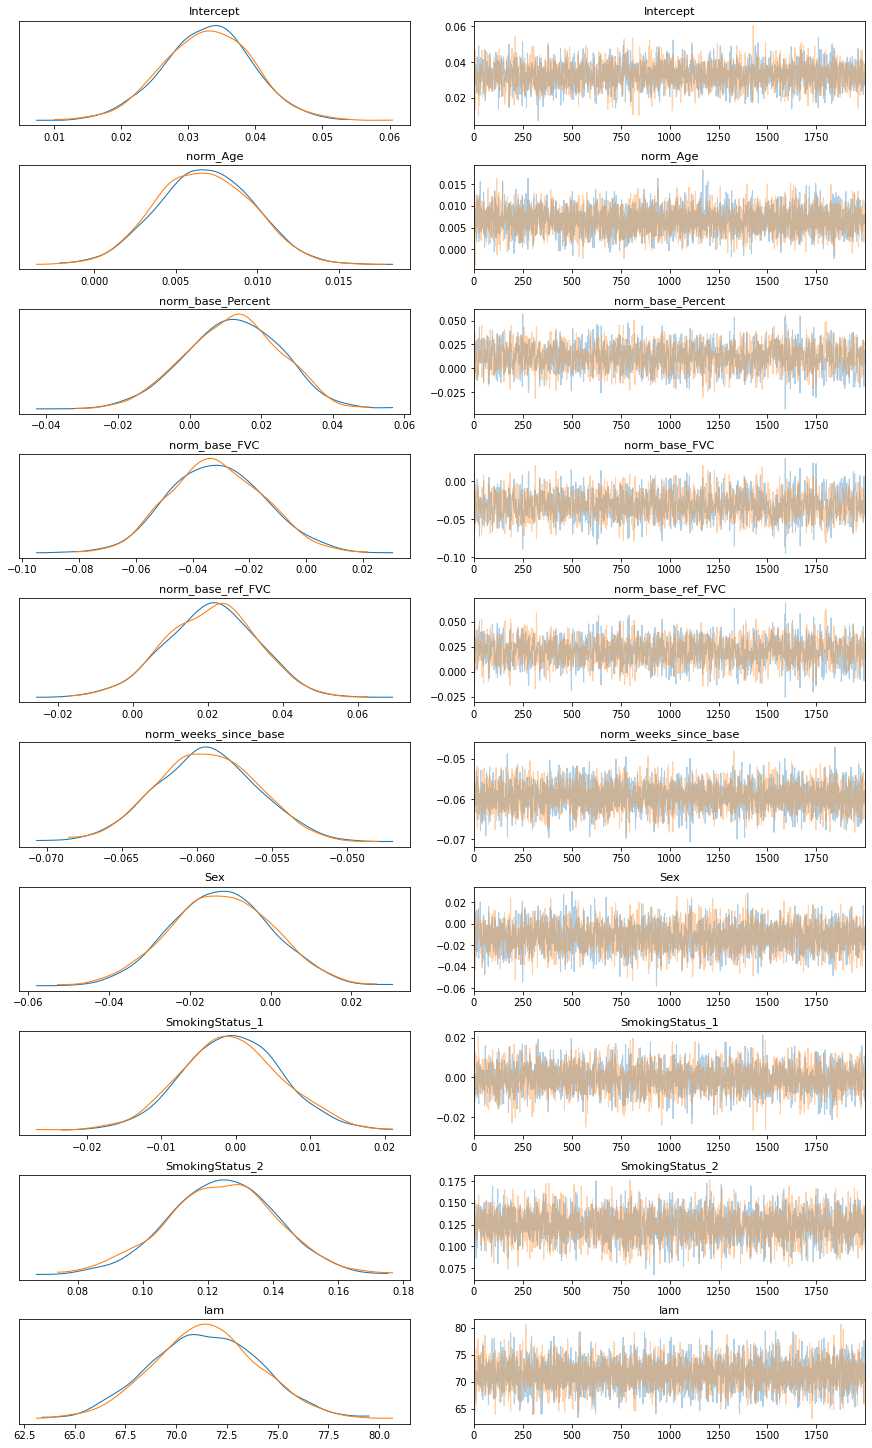

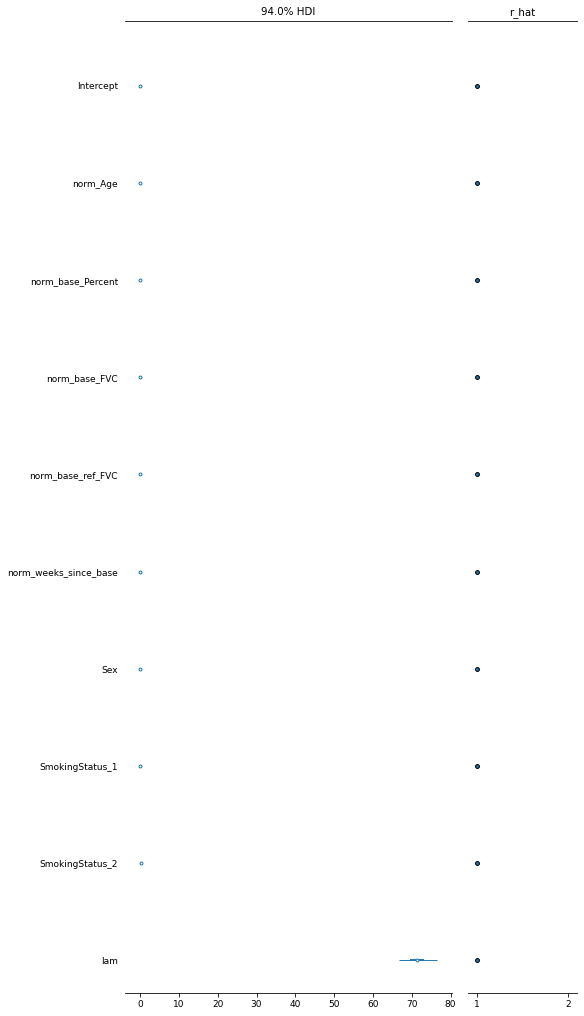

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.638651367597466, 6.6122764429519085]
0.00027428912214323004 [ 0.01821069 -0.01544825 -0.00817565 -0.01018137 -0.07339257 -0.00140707
  0.00907286  0.17035782]


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


In [ ]:
losses=[]
for adf,bdf in folds:
    train_loss,test_loss=train(adf,bdf, LR_FEATS, TARGET)
    losses.append([train_loss,test_loss])
    print("loss: ", losses[-1])    

In [25]:
losses

[[6.620104214225069, 6.690837014641548],
 [6.634609568399486, 6.626062360523324],
 [6.6079580206943, 6.755309537925161],
 [6.638651367597466, 6.6122764429519085],
 [6.653446510281398, 6.534578386574994]]

In [29]:
print("AAAAAAA " + ",".join(FEATS) +" "+ str(dict(zip(["train","test"], np.mean(losses,0)))))

AAAAAAA norm_Age,norm_base_Percent,norm_base_FVC,norm_base_ref_FVC,norm_weeks_since_base,Sex,SmokingStatus_1,SmokingStatus_2 {'train': 6.630953936239544, 'test': 6.643812748523388}
